#PhlyGreen Tutorial 

Import packages

In [1]:
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft

Define input dictionaries

In [5]:
ConstraintsInput = {'speed': np.array([0.41, 70, 100, 0.3, 0.41, 0.35, 59.]) ,
                    'speedtype': ['Mach','TAS','TAS','Mach','Mach','Mach','TAS']   ,
                    'beta': np.array([0.97,1.,0.95, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([6000., 100., 1600., 5000, 7600., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 1300,
                    'Climb Gradient': 0.08,
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [6]:
MissionInput = {'Range Mission': 750,
                'Range Diversion': 100,
                'Beta start': 0.95,
                'Payload Weight': (4560),
                'Crew Weight': (95*3)}

In [7]:
MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 1.4*59, 'StartAltitude': 100, 'EndAltitude': 1600}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 1600, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.04, 'Speed': 100, 'StartAltitude': 4500, 'EndAltitude': 6000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.41, 'Altitude': 6000}, 'Supplied Power Ratio':{'phi_start': 0.0225104, 'phi_end':0.0148335 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 100, 'StartAltitude': 6000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 1.4*59, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.3, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0225104, 'phi_end':0.0148335}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 110, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [8]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine': 0.3,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive': 0.9,
                   'Specific Power Powertrain': [3600,0]
                   }

In [9]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}}}

Import input dictionaries

In [10]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput

Set aircraft power configuration

In [11]:
myaircraft.Configuration = 'Traditional'

Set inputs

In [12]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

Either run the Constraint Analysis....

In [13]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3323.757575757576
Design P/W:  152.87149053090695
----------------------------------------


... or assign a wing loading

In [14]:
#myaircraft.DesignWTOoS = 2121

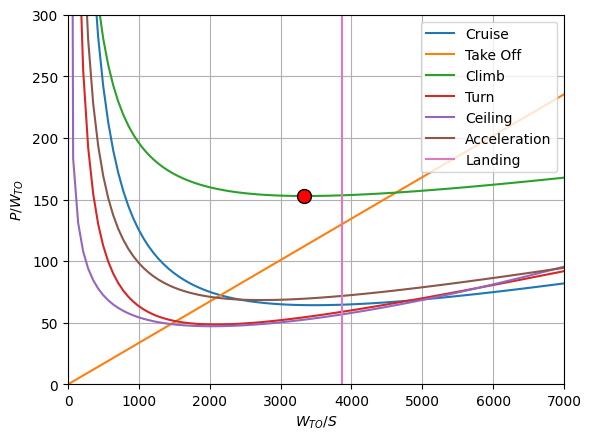

In [15]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWClimb, label='Climb')
#plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEI, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$P/W_{TO}$')
plt.show()

Run Mission analysis to define the aircraft's masses

In [16]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [17]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * 9.81

A summary of the preliminary design:

In [18]:
print('----------------------------------------')
print('Powertrain mass: ',myaircraft.weight.WPT)
print('Fuel mass: ', myaircraft.weight.Wf)
print('Structure: ', myaircraft.weight.WStructure)
print('Empty Weight: ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('----------------------------------------')
print('Takeoff Weight: ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface: ', myaircraft.WingSurface, ' m^2')
print('Sizing phase for thermal powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PFoW > myaircraft.mission.TO_PFoW else 'Takeoff peak power'  )

----------------------------------------
Powertrain mass:  705.4948903863802
Fuel mass:  1051.2490101108463
Structure:  9509.546949040478
Empty Weight:  10500.041839426858
----------------------------------------
Takeoff Weight:  16111.258024204575
Wing Surface:  47.552036397065635  m^2
Sizing phase for thermal powertrain  Climb/Cruise peak power


Some plots:

In [19]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

In [20]:
myaircraft.mission.TO_PFoW/(myaircraft.weight.WTO * myaircraft.powertrain.Traditional()[0])

111.77692723934472

In [21]:
myaircraft.mission.Max_PFoW/(myaircraft.weight.WTO * myaircraft.powertrain.Traditional()[0])

136.2011150067305

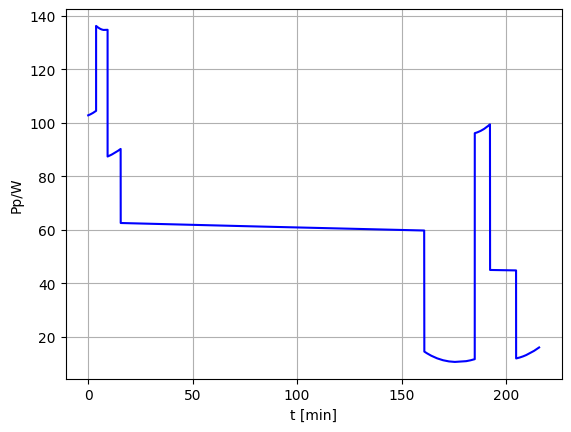

In [22]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

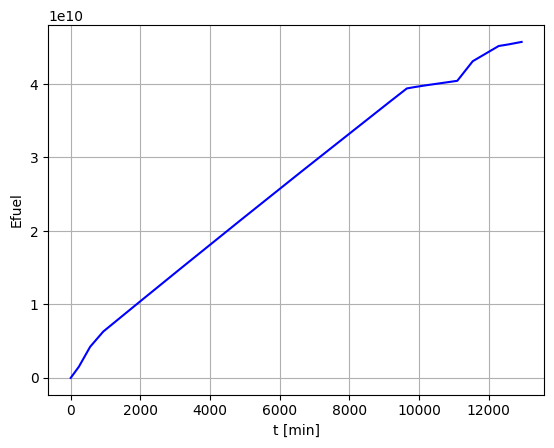

In [23]:
plt.plot(times,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

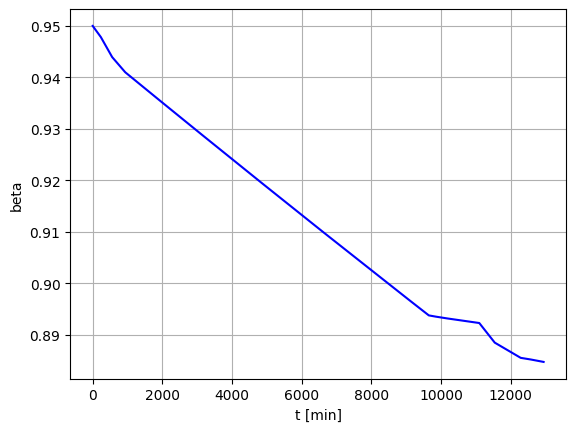

In [24]:
plt.plot(times,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

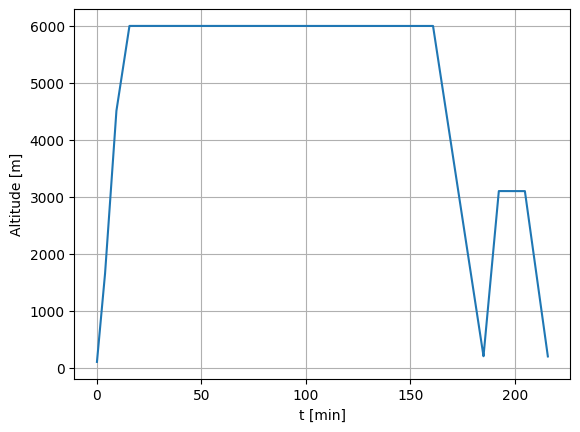

In [25]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()